In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import requests
import pandas as pd
import time


In [9]:
# Timestamps pour les 5 dernieres années
end_time = int(time.time())
start_time = end_time - (5 * 365 * 24 * 60 * 60)  

url = f"https://query1.finance.yahoo.com/v8/finance/chart/BTC-EUR?interval=1d&period1={start_time}&period2={end_time}"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()

    timestamps = data["chart"]["result"][0]["timestamp"]
    open = data["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = data["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = data["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = data["chart"]["result"][0]["indicators"]["quote"][0]["close"]

    df = pd.DataFrame({"date": timestamps, "open": open, "high": high, "low": low, "close": close})
    df["date"] = pd.to_datetime(df["date"], unit="s") 

    df.to_csv("bitcoin_historical_from_2020_to_now.csv", index=False)

    print(df.head())  

else:
    print(f"Erreur {response.status_code}: Impossible de récupérer les données")
    print(response.text)


        date         open         high          low        close
0 2020-02-12  9343.948242  9524.737305  9343.948242  9495.313477
1 2020-02-13  9493.387695  9616.425781  9319.048828  9421.151367
2 2020-02-14  9418.541992  9523.971680  9341.442383  9521.362305
3 2020-02-15  9522.969727  9548.245117  9116.950195  9130.796875
4 2020-02-16  9130.571289  9282.718750  8976.573242  9163.173828


In [10]:
# Chargement des données
data = pd.read_csv("C:/Users/ethan/OneDrive/Bureau/ESIR 3/IA/bitcoin_historical_from_2020_to_now.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [11]:
# Prétraitement des données
features = data.values  # Les colonnes sont dans l'ordre : Ouverture, Plus haut, Plus bas, Volume, Fermer
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Pour X, on prend toutes les colonnes sauf la dernière (donc: Ouverture, Plus haut, Plus bas, Volume)
        X.append(data[i:i + sequence_length, :-1])
        # Pour y, on prend la dernière colonne, ici "Fermer"
        y.append(data[i + sequence_length, -1])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)


C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Erreur Quadratique Moyenne (MSE) sur l'ensemble de test: 116818156.67519616


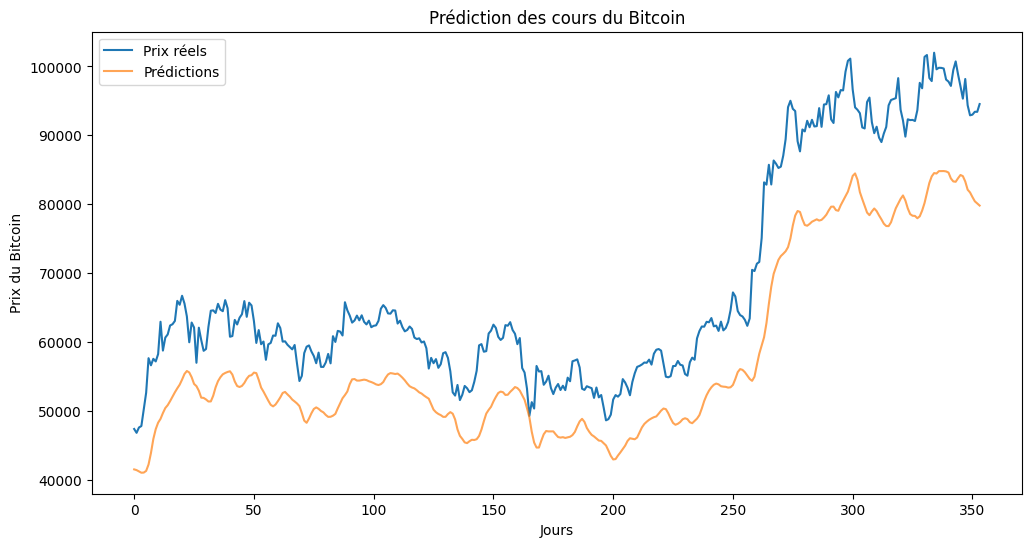

In [12]:
# Division des ensembles d'entraînement et de test (80% entraînement, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Classe personnalisée pour le modèle GRU
class GRUModel(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, dropout=0.2, optimizer='adam', batch_size=32, epochs=10):
        self.units = units
        self.dropout = dropout
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def build_model(self):
        model = Sequential([
            GRU(self.units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            Dropout(self.dropout),
            GRU(self.units, return_sequences=False),
            Dropout(self.dropout),
            Dense(1)
        ])
        model.compile(optimizer=self.optimizer, loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0)

# Meilleurs hyperparamètres trouvés (par exemple via GridSearchCV)
best_params = {
    'batch_size': 32,
    'dropout': 0.3,
    'epochs': 20,
    'optimizer': 'rmsprop',
    'units': 50
}

# Entraînement du modèle avec les meilleurs hyperparamètres
best_model = GRUModel(
    units=best_params['units'],
    dropout=best_params['dropout'],
    optimizer=best_params['optimizer'],
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs']
)

best_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Pour inverser la normalisation, on reconstruit un tableau à 5 colonnes :
# Les 4 premières colonnes proviennent du dernier pas de temps de la séquence d'entrée
# La 5ème colonne est la valeur cible (Volume) (y ou y_pred)
# IMPORTANT : On utilise X_test[:, -1, :] et non X_test[:, -1, :-1] afin d'obtenir les 4 features d'origine.
X_test_last_feature = X_test[:, -1, :]  # Shape attendue : (n_samples, 4)

# Concaténation avec y_test pour obtenir un tableau (n_samples, 5)
y_test_with_features = np.concatenate([X_test_last_feature, y_test.reshape(-1, 1)], axis=1)


# Inversion de la normalisation pour récupérer les valeurs réelles du Volume
y_test_inv = scaler.inverse_transform(y_test_with_features)[:, -1]

# Idem pour les prédictions
y_pred_with_features = np.concatenate([X_test_last_feature, y_pred.reshape(-1, 1)], axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_with_features)[:, -1]

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Erreur Quadratique Moyenne (MSE) sur l'ensemble de test: {mse}")

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Prix réels')
plt.plot(y_pred_inv, label='Prédictions', alpha=0.7)
plt.title('Prédiction des cours du Bitcoin')
plt.xlabel('Jours')
plt.ylabel('Prix du Bitcoin')
plt.legend()
plt.show()